In [1]:
import os
import pandas as pd 
import numpy as np 

import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns
import yaml
import re

import openmatrix as omx


In [2]:
## The objective of this notebook is to have a scrip automatically summarize scenario results.
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.3


In [3]:
df = pd.DataFrame({'a':['1', '2', '3'], 'b':['4', '5', '6']})
int(df['a'].isin(['9', '1']).sum())

1

## Reads all policy scenarios in carb/policy_analysis directory. Iterates over each policy. 
## For each policy get: 

* 1. Household Vehicle Ownership 
* 2. Average Trip Lenght (miles/day) [Drive alone, Share Ride, Public Transit, Bike, Walk]
* 3. Average Travel Time by Trip Purpose [Commte Trip, Non-commute trip]
* 4. Average Travel Time by Mode [Drive Alone, TNC Alone, Shared Ride, TNC Shared, Public Transit, Bike, Walk]. 
* 5. Average Travel Time for Low-income populations (minutos) 
* 6. Mode Share [Drive Alone, TNC Alone, Shared Ride, TNC Shared, Public Transit, Bike, Walk]. 
* 7. Seat Utilization 
* 8. Transit RiderShip (Average daily boardings) 
* 9. Total VMT per weekday (all vehicles) 
* 10. VMT per capita 


In [4]:
def read_policy_settings():
    a_yaml_file = open('policies.yaml')
    settings = yaml.load(a_yaml_file, Loader=yaml.FullLoader)
    return settings

def od_matrix_lookup(origin, destination, matrix):
    ''' Returns the distance between origin and estiantion in miles
    Parameters:
    -----------
    - origing: 1-d array-like. origins ID 
    - destination: 1- d array_like. destination ID 
    - matrix: 2-d array-like. Origin-destiantion matrix for a given metric. 
                              Rows are origins, columns are destinations 
                              
    Returns: 
    1-d array of the origin-destination metric. 
    '''
    assert origin.ndim == 1, 'origin should be a 1-d array'
    assert destination.ndim == 1, 'destination should be 1-d array'
    assert matrix.ndim == 2, 'distance matrix should be 2-d array'
    assert origin.shape == destination.shape, 'origin and destination should have the same shape'
    
    #Transform array-like to numpy array in case they are not
    #Substract 1 because distance matrix starts in ZERO
    origin = np.array(origin) - 1
    destination = np.array(destination) - 1
    return matrix[origin, destination]


def od_matrix__time_lookup(period, mode, origin, destination, matrix):
    ''' Returns the distance between origin and estiantion in miles
    Parameters:
    -----------
    - origing: 1-d array-like. origins ID 
    - destination: 1- d array_like. destination ID 
    - matrix: 4-d array-like. Each dimension correspond to >>
        - period:
        - mode_index:
        - origin:
        - destiantion:
                              
    Returns: 
    1-d array of the origin-destination metric. 
    '''
    assert origin.ndim == 1, 'origin should be a 1-d array'
    assert destination.ndim == 1, 'destination should be 1-d array'
    assert period.ndim == 1, 'origin should be a 1-d array'
    assert period.ndim == 1, 'destination should be 1-d array'
    assert matrix.ndim == 4, 'distance matrix should be 4-d array'
    assert origin.shape == destination.shape, 'origin and destination should have the same shape'
    
    #Transform array-like to numpy array in case they are not
    #Substract 1 because distance matrix starts in ZERO
    origin = np.array(origin) - 1
    destination = np.array(destination) - 1
    return matrix[period, mode, origin, destination]

def time_skims(skims):
    """
    Return time skims for each mode of transportation. 
    Time Period Index: 
    - 'EA'= 0
    - 'AM'= 1
    - 'MD'= 2 
    - 'PM'= 3
    - 'EV'= 4
    Mode Index:
    -'DRIVEALONEFREE': 0, 
    -'DRIVEALONEPAY':1, 
    -'SHARED2FREE': 2, 
    -'SHARED3FREE': 3, 
    -'SHARED2PAY':4, 
    -'SHARED3PAY':5, 
    -'WALK': 6, 
    -'BIKE': 7, 
    -'WALK_HVY': 8,
    -'WALK_LOC': 9,
    -'WALK_EXP': 10,
    -'WALK_COM': 11,
    -'WALK_LRF': 12,
    -'DRIVE_HVY': 13, 
    -'DRIVE_LOC': 14,
    -'DRIVE_EXP': 15,
    -'DRIVE_COM': 16,
    -'DRIVE_LRF': 17,
    -'TNC_SINGLE': 0,
    -'TNC_SHARED': 0, 
    -'TAXI': 0
    
    Return:
    - four-dimensional matrix. (time_period, mode, origin, destination)
    """
    periods = ['EA', 'AM', 'MD', 'PM', 'EV']
    driving_modes = ['SOV', 'SOVTOLL','HOV2','HOV2TOLL', 'HOV3','HOV3TOLL']
    transit_modes = ['HVY','LOC','EXP','COM','LRF']

    time_skims = []
    for period in periods:
        driving_skims = []
        walk_transit = []
        drive_transit = []
        for mode in driving_modes:
            time_mtx = np.array(skims['{0}_TIME__{1}'.format(mode, period)])
            driving_skims.append(time_mtx)

        for mode in transit_modes:
            walk_time_skim = (np.array(skims['WLK_{0}_WLK_WAIT__{1}'.format(mode, period)]) +\
             np.array(skims['WLK_{0}_WLK_IWAIT__{1}'.format(mode, period)]) +\
             np.array(skims['WLK_{0}_WLK_XWAIT__{1}'.format(mode, period)]) +\
             np.array(skims['WLK_{0}_WLK_WAUX__{1}'.format(mode, period)]) +\
             np.array(skims['WLK_{0}_WLK_TOTIVT__{1}'.format(mode, period)]))/100
            walk_transit.append(walk_time_skim)

            drive_time_skim = (np.array(skims['DRV_{0}_WLK_DTIM__{1}'.format(mode, period)]) +\
             np.array(skims['DRV_{0}_WLK_IWAIT__{1}'.format(mode, period)]) +\
             np.array(skims['DRV_{0}_WLK_XWAIT__{1}'.format(mode, period)]) +\
             np.array(skims['DRV_{0}_WLK_WAUX__{1}'.format(mode, period)]) +\
             np.array(skims['DRV_{0}_WLK_TOTIVT__{1}'.format(mode, period)]))/100
            drive_transit.append(drive_time_skim)

        bike_time = np.array(skims['DISTBIKE'])*60/12 #12 miles/hour
        walk_time = np.array(skims['DISTWALK'])*60/3 #3 miles/hour
        
        period_time_skims = np.stack((driving_skims + \
                                      [walk_time] + \
                                      [bike_time] + \
                                      walk_transit + \
                                      drive_transit))
        
        time_skims.append(period_time_skims)
        
    return np.stack(time_skims)

In [5]:
def driving_skims(skims):
    """
    Return time skims for each mode of transportation. 
    Time Period Index: 
    - 'EA'= 0
    - 'AM'= 1
    - 'MD'= 2 
    - 'PM'= 3
    - 'EV'= 4
    Mode Index:
    -'DRIVE_HVY': 0, 
    -'DRIVE_LOC': 1,
    -'DRIVE_EXP': 2,
    -'DRIVE_COM': 3,
    -'DRIVE_LRF': 4,
    - OTHER MODE': 5
    
    Return:
    - four-dimensional matrix. (time_period, mode, origin, destination)
    """
    periods = ['EA', 'AM', 'MD', 'PM', 'EV']
    transit_modes = ['HVY','LOC','EXP','COM','LRF']

    time_skims = []
    for period in periods:
        driving_access_skims = []
        for mode in transit_modes:
            drive_access_skim = (np.array(skims['DRV_{0}_WLK_DDIST__{1}'.format(mode, period)]))/100
            driving_access_skims.append(drive_access_skim)
            shape = drive_access_skim.shape

        
        period_time_skims = np.stack(driving_access_skims + [np.zeros(shape)])
        
        time_skims.append(period_time_skims)
        
    return np.stack(time_skims)

In [134]:
def add_results_variables(trips, households, skims):
    df = trips.copy()
    
    #Skims values 
    dist = np.array(skims['DIST'])
    time_skims_final = time_skims(skims)
    driving_access_skims = driving_skims(skims)
    
    # Mappings 
    settings = read_policy_settings()
    carb_mode_mapping = settings['carb_mode_mapping']
    mode_index_mapping = settings['mode_index_mapping']
    drv_acc_mode_index_mapping = settings['driving_access_mode_index_mapping']
    commute_mapping = settings['commute_mapping']
    
    df['dist_miles'] = od_matrix_lookup(df.origin, df.destination, dist)
    df['carb_mode'] = df.trip_mode.replace(carb_mode_mapping)
    df['commute'] = df.primary_purpose.replace(commute_mapping)
    df['period'] = pd.cut(df.depart, (0,5,10,15,19,24), labels = [0,1,2,3,4]).astype(int)
    df['mode_index'] = df.trip_mode.replace(mode_index_mapping)
    df['travel_time'] = od_matrix__time_lookup(df.period, df.mode_index, 
                                              df.origin, df.destination,
                                              time_skims_final)
    df['driving_access_mode_index'] = df.trip_mode.replace(drv_acc_mode_index_mapping)
    df['driving_access'] = driving_access_skims[df.period, df.driving_access_mode_index,
                                                df.origin -1, df.destination -1]

    df['VMT'] = df['driving_access']
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['DRIVEALONEFREE','DRIVEALONEPAY']), 
                            df.dist_miles)
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['SHARED2FREE','SHARED2PAY']), 
                            df.dist_miles/2)
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['SHARED3FREE','SHARED3PAY']), 
                            df.dist_miles/3)
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['TNC_SINGLE']), df.dist_miles)
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['TNC_SHARED']), df.dist_miles/2.5)
    df['VMT'] = df.VMT.mask(df.trip_mode.isin(['TAXI']), df.dist_miles)
    
    df_income = df.merge(households[['income']], how = 'left', 
            left_on = 'household_id', right_index = True)

    df_income['income_category'] = pd.cut(df_income.income, 
                               [-np.inf, 80000, 150000, np.inf], 
                               labels = ['low', 'middle','high'])
    
    return df_income

############################
## Performance Indicators ##
############################

def average_vehicle_ownership(households):
    return households.auto_ownership.mean()

def average_commute_trip_lenght(trips):
    return trips.groupby('carb_mode').agg({'dist_miles':'mean'})

def average_traveltime_purpose(trips):
    return trips.groupby('commute').agg({'travel_time':'mean'})

def average_traveltime_mode(trips):
    return trips.groupby('carb_mode').agg({'travel_time':'mean'})

def average_traveltime_income(trips):
    return trips.groupby('income_category').agg({'travel_time':'mean'})

def mode_shares(trips):
    return trips.carb_mode.value_counts(normalize=True)

def seat_utilization(trips):
    veh_1 = trips.trip_mode.value_counts()[['DRIVEALONEFREE','DRIVEALONEPAY']].sum()
    # veh_2 = trips.trip_mode.value_counts()[['SHARED2FREE','SHARED2PAY']].sum()
    # veh_3 = trips.trip_mode.value_counts()[['SHARED3FREE','SHARED3PAY']].sum()
    veh_2 = trips.trip_mode.value_counts()[['SHARED2FREE']].sum()
    veh_3 = trips.trip_mode.value_counts()[['SHARED3FREE']].sum()
    return (veh_1 + veh_2 + veh_3)/(veh_1 + veh_2/2 + veh_3/3)

def transit_ridersip(trips):
    return trips.carb_mode.isin(['Public Transit']).sum()

def total_vmt(trips):
    return trips['VMT'].sum()

def vmt_per_capita(trips, persons):
    population = persons.shape[0]
    return total_vmt(trips)/population

In [135]:
def get_scenario_resutls(path):
    
    #Important tables
    
    scenario_name = re.search('\/(?:.(?!\/))+$' ,path)
    scenario_name = scenario_name.group(0)[1:]
    
    households = pd.read_csv(os.path.join(path,'output','final_households.csv'), 
                         index_col = 'household_id')
    persons = pd.read_csv(os.path.join(path,'output','final_persons.csv'), 
                     index_col = 'person_id')
    trips = pd.read_csv(os.path.join(path,'output','final_trips.csv'), 
                   index_col = 'trip_id')

    skims = omx.open_file(os.path.join(path, 'data', 'skims.omx'),'r')
    
    df = add_results_variables(trips, households, skims)
    
    dict_results = {}
    dict_results['Household Vehicle Ownership'] = average_vehicle_ownership(households)
    dict_results['Average Trip Length'] = average_commute_trip_lenght(df).to_dict()['dist_miles']
    dict_results['Average Travel Time by Purpose'] = average_traveltime_purpose(df).to_dict()['travel_time']
    dict_results['Average Travel Time by Mode'] = average_traveltime_mode(df).to_dict()['travel_time']
    dict_results['Average Travel Time by Income'] = average_traveltime_income(df).to_dict()['travel_time']
    dict_results['Mode Shares'] = mode_shares(df).to_dict()
    dict_results['Seat Utilization'] = seat_utilization(df)
    dict_results['Transit Ridership'] = transit_ridersip(df)
    dict_results['Total VMT'] = total_vmt(df)
    dict_results['VMT per Capita'] = vmt_per_capita(df, persons)
    dict_results['name'] = scenario_name
    
    return dict_results

In [136]:
def get_metric(metric, args):
    values = []
    names = []
    for arg in args:
        values.append(arg[metric])
        names.append(arg['name'])
    return values, names
    
def build_df_multi(values, names):
    dfs = []
    for v,n in zip(values,names):
        df = pd.DataFrame.from_dict(data = v, orient = 'index')
        df['name'] =  n
        df.reset_index(inplace = True)
        df.columns = ['category','values','name']
        dfs.append(df)
    return pd.concat(dfs)

In [157]:
def plot_single(metric, title, ylabel, *args):
    values = []
    names = []
    for arg in args:
        values.append(arg[metric])
        names.append(arg['name'])
    
    df = pd.DataFrame({'values': values, 'names': names})
    
    fig = plt.figure(figsize = (10,7))
    ax = sns.barplot( x = 'names',y = 'values', data = df)
    ax.bar_label(ax.containers[0],fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel('')
    ax.set_title(title, fontsize = 18, fontweight = 'bold')
#     plt.suptitle(subtile, fontsize=14, y =0.92)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylim([13, 14.5])

In [138]:
def plot_categories(metric, title, ylabel, legend_label,  *args):
    values, names = get_metric(metric, args)
    df = build_df_multi(values, names)
#     print(df)
    fig = plt.figure(figsize = (10,7))
    ax = sns.lineplot(data = df, x ='name', y='values', hue = 'category', style="category")
    ax.legend(bbox_to_anchor=(1.01,1), loc="upper left", title =legend_label, fontsize = 12)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel('')
    ax.set_title(title, fontsize = 18, fontweight = 'bold')
#     plt.suptitle('Average Travel Time by Purpose', fontsize=14, y =0.92)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=12)

In [139]:
def plot_mode_shares(*args):
    modes, names = get_metric('Mode Shares', args)
    dfs = []
    for m, n in zip(modes, names):
        df = pd.DataFrame(m, index = [n])
        df.index.name = 'scenario'
        dfs.append(df)
#     print(df)
    cols_order = ['Drive Alone', 'Shared Ride', 'Public Transit', 
                  'Bike', 'Walk', 'TNC - Pooled',  'TNC - Ride Alone']
    df = pd.concat(dfs)
    df = df[cols_order].cumsum(axis = 1)
    
    fig = plt.figure(figsize = (10,7))
    for col in df:
        ax = sns.lineplot(x = df.index, y = col, data = df, legend = 'brief', label = col)

    plt.fill_between(df.index, df['Drive Alone'], [0.2]*df.shape[0], alpha=0.5)
    plt.fill_between(df.index, df['Drive Alone'], df['Shared Ride'], alpha=0.5)
    plt.fill_between(df.index, df['Shared Ride'], df['Public Transit'], alpha=0.5)
    plt.fill_between(df.index, df['Public Transit'], df['Bike'], alpha=0.5)
    plt.fill_between(df.index, df['Bike'], df['Walk'], alpha=0.5)
    plt.fill_between(df.index, df['Walk'], df['TNC - Pooled'], alpha=0.5)
    plt.fill_between(df.index, df['TNC - Pooled'], df['TNC - Ride Alone'], alpha=0.5)

    plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", title ='Mode', fontsize = 12)
    plt.xlabel('')
    plt.ylabel('Mode Share (%)', fontsize = 14)
    plt.title('Mode Share', fontsize = 18, fontweight = 'bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14);

In [168]:
settings = read_policy_settings()
policies = list(settings['policies'].keys())

In [169]:
policies

['transit_frequency',
 'transit_operations',
 'shared_tnc_price',
 'shared_tnc_waiting_times',
 'VMT_fees',
 'hov_lanes']

In [185]:
settings['policies']['shared_tnc_price']['scenarios']

{'25%_Reduction': 0.75}

In [38]:
def read_yaml(path):
    a_yaml_file = open(path)
    settings = yaml.load(a_yaml_file, Loader=yaml.FullLoader)
    return settings

In [190]:
policy_scenario = 'shared_tnc_price'

p1 = os.path.join('policy_analysis', policy_scenario, '50%_Increase', 'results.yaml')
r1 = read_yaml(p1)

p2 = os.path.join('policy_analysis', policy_scenario, 'Current_Fare', 'results.yaml')
r2 = read_yaml(p2)

p3 = os.path.join('policy_analysis', policy_scenario, '25%_Reduction', 'results.yaml')
r3 = read_yaml(p3)

# p4 = os.path.join('policy_analysis', policy_scenario, '125%_Increased', 'results.yaml')
# r4 = read_yaml(p4)

# p5 = os.path.join('policy_analysis', policy_scenario, '150%_Increased', 'results.yaml')
# r5 = read_yaml(p5)


# path = os.path.join('policy_analysis', policy_scenario, 'scenario_2')
# results_2 = get_scenario_resutls(path)

# path = os.path.join('policy_analysis', policy_scenario, 'scenario_3')
# results_3 = get_scenario_resutls(path)

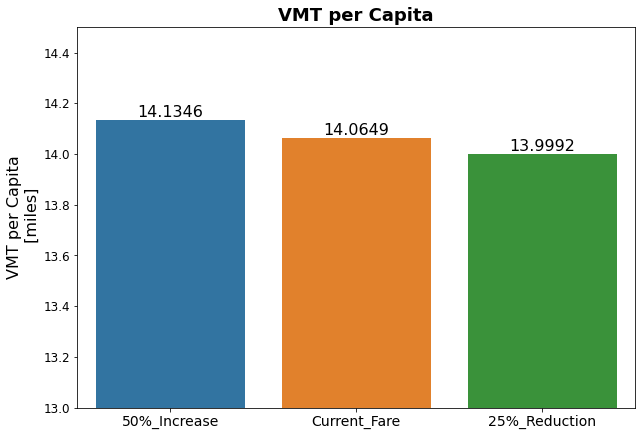

In [191]:
plot_single('VMT per Capita', 'VMT per Capita', 'VMT per Capita\n [miles]', r1, r2, r3)

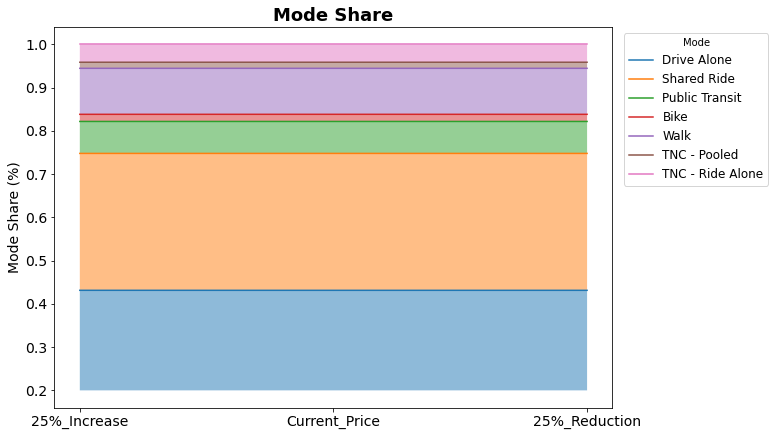

In [188]:
plot_mode_shares(r1, r2, r3)

In [128]:
bool(0)

False

In [72]:
get_metric('Average Trip Length', (r1, r2))

# # def get_metric(metric, args):
# metric = 'Average Trip Length'
# args = (p1, p2)
# values = []
# names = []
# for arg in args:
#     print(arg)
#     values.append(arg[metric])
#     names.append(arg['name'])
#     return values, names

([{'Bike': 2.3393295087845147,
   'Drive Alone': 7.263793203909206,
   'Public Transit': 8.48551074757465,
   'Shared Ride': 5.430124563132832,
   'TNC - Pooled': 4.911463217461603,
   'TNC - Ride Alone': 3.274833875300437,
   'Walk': 0.8267105542578073},
  {'Bike': 2.3202676733013075,
   'Drive Alone': 7.278027567970832,
   'Public Transit': 8.373786924261504,
   'Shared Ride': 5.465866645346939,
   'TNC - Pooled': 4.912437950360287,
   'TNC - Ride Alone': 3.2878655578655587,
   'Walk': 0.8259226583549087}],
 ['50%_Reduction', '25%_Reduction'])

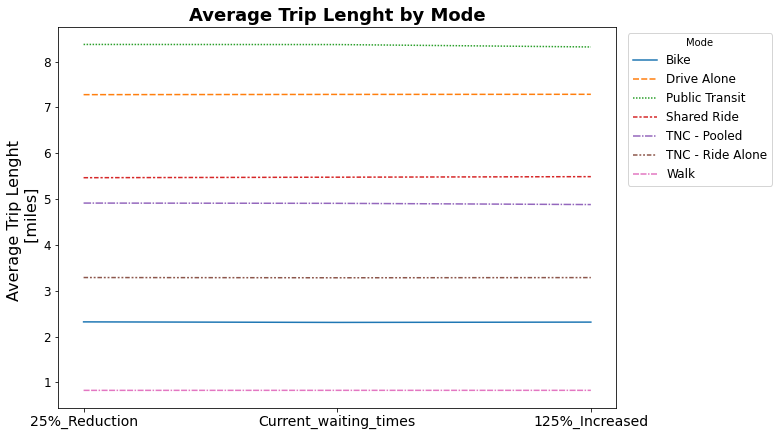

In [77]:
plot_categories('Average Trip Length', 'Average Trip Lenght by Mode', 
                'Average Trip Lenght \n [miles]', 'Mode', r2, r3, r4)

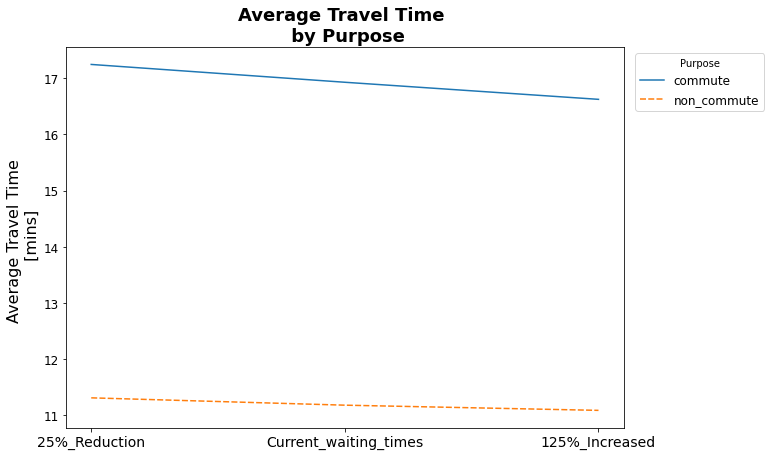

In [78]:
plot_categories('Average Travel Time by Purpose', 'Average Travel Time \n by Purpose', 
                'Average Travel Time \n [mins]', 'Purpose', r2, r3, r4)

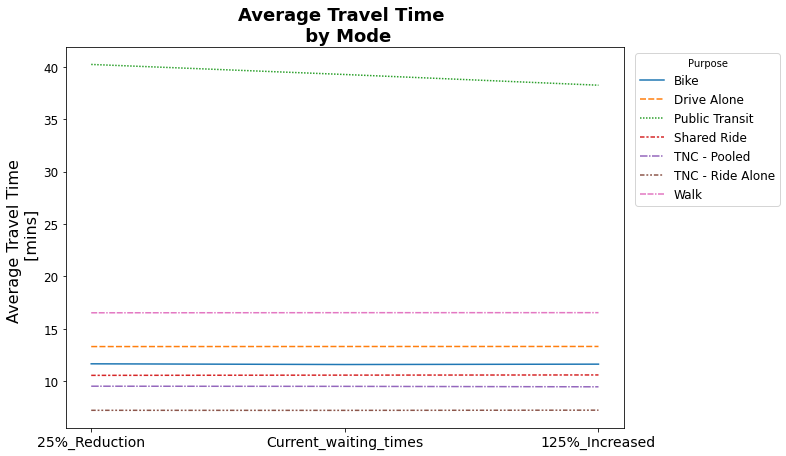

In [79]:
plot_categories('Average Travel Time by Mode', 'Average Travel Time \n by Mode', 
                'Average Travel Time \n [mins]', 'Purpose', r2, r3, r4)

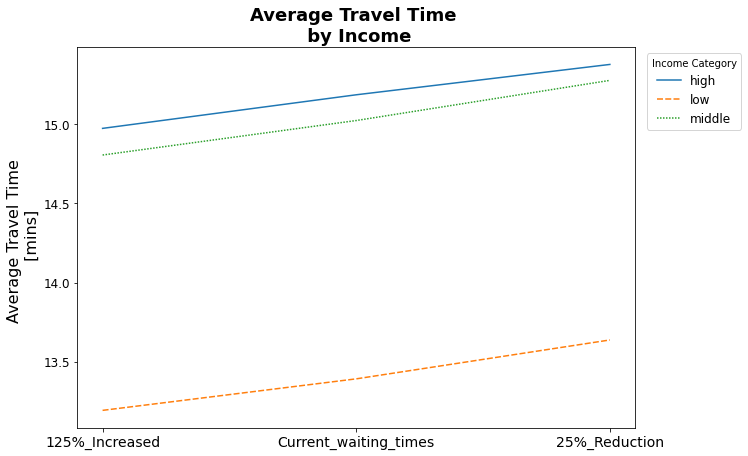

In [88]:
plot_categories('Average Travel Time by Income', 'Average Travel Time \n by Income', 
                'Average Travel Time \n [mins]', 'Income Category', r4, r3, r2)

                   Bike  Drive Alone  Public Transit  Shared Ride  \
scenario                                                            
25%_Reduction  0.016323     0.427922        0.080024     0.315291   

               TNC - Pooled  TNC - Ride Alone      Walk  
scenario                                                 
25%_Reduction      0.013993          0.040415  0.106032  


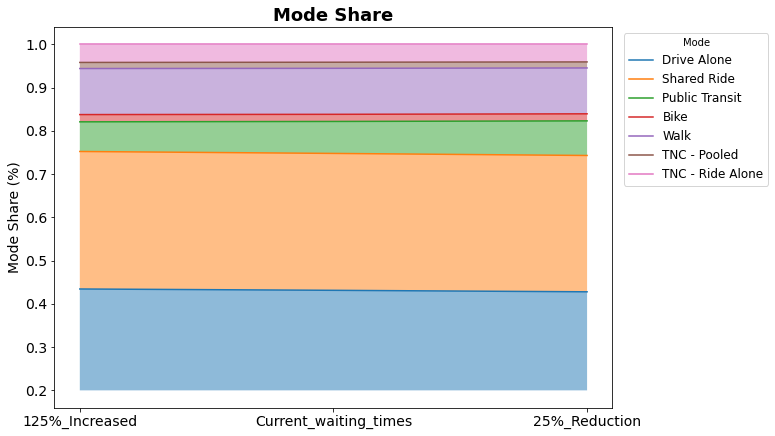

In [96]:
plot_mode_shares(r4, r3, r2)

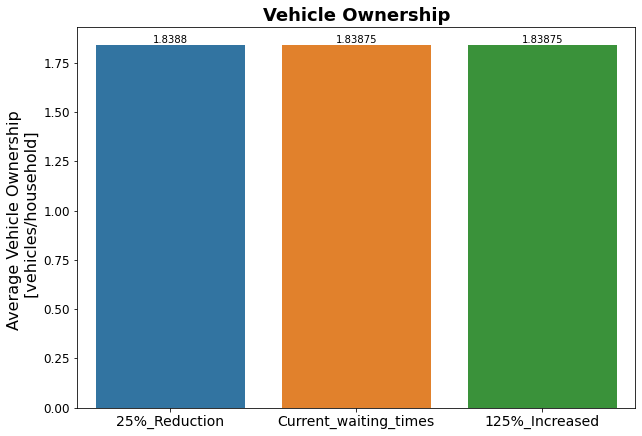

In [82]:
plot_single('Household Vehicle Ownership', 'Vehicle Ownership', 
            'Average Vehicle Ownership \n [vehicles/household]', r2, r3, r4)

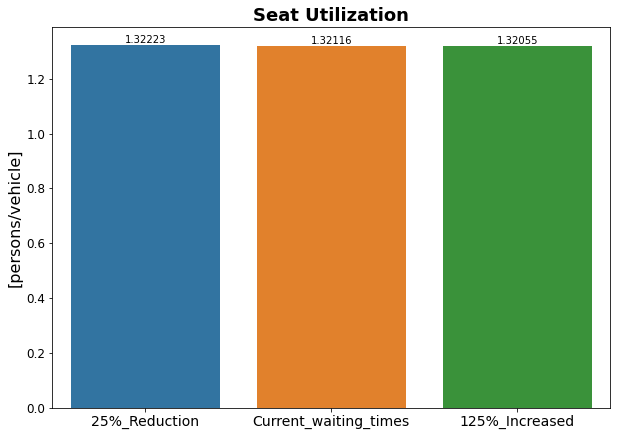

In [83]:
plot_single('Seat Utilization', 'Seat Utilization', '[persons/vehicle]', r2, r3, r4)

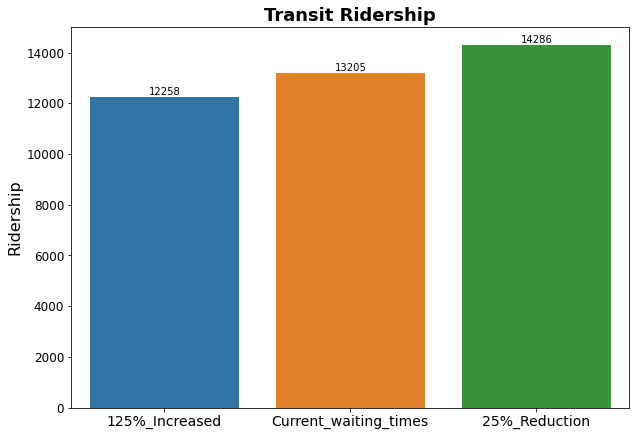

In [97]:
plot_single('Transit Ridership', 'Transit Ridership', 'Ridership', r4, r3, r2)

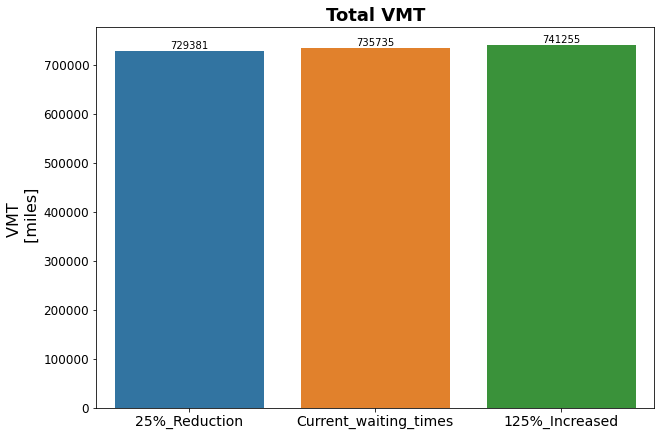

In [85]:
plot_single('Total VMT', 'Total VMT', 'VMT \n [miles]', r2, r3, r4)

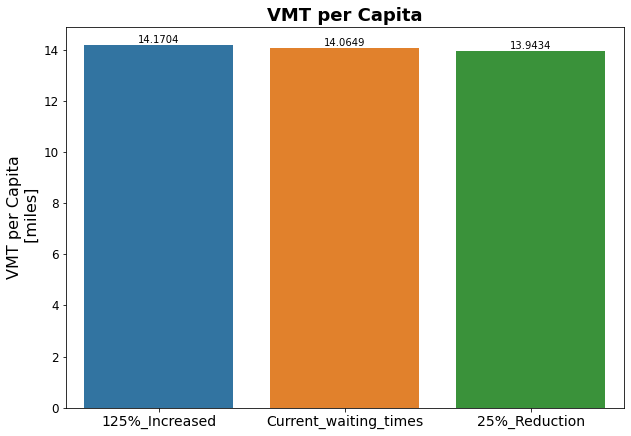

In [87]:
plot_single('VMT per Capita', 'VMT per Capita', 'VMT per Capita\n [miles]', r4, r3, r2)

# Transit Cost per Mile

In [6]:
skims = omx.open_file(os.path.join('bay_area_base', 'data', 'skims.omx'),'r')

In [8]:
dist = np.array(skims['DIST'])

In [10]:
dist.shape

(1475, 1475)

In [14]:
mx = pd.Series(skims.listMatrices())

In [19]:
fare_matrices = list(mx[mx.str.contains('_FAR__AM')])

In [27]:
cost = np.array(skims[fare_matrices[0]])

In [28]:
cost_mile = cost/dist

In [35]:
cost_mile[cost_mile != 0].mean()

38.831035987971

In [36]:
means = []
for fare in fare_matrices:
    cost = np.array(skims[fare])
    cost_mile = cost/dist
    mean_cost_mile = cost_mile[cost_mile != 0].mean()
    means.append(mean_cost_mile)

In [39]:
np.array(means).mean()

28.394370867506574

In [40]:
means

[38.831035987971,
 27.325148420933147,
 20.83795235984804,
 23.939532582834538,
 21.045522155114366,
 47.42836505651905,
 25.414045821104914,
 30.729151611555405,
 27.088985043578873,
 27.171692864980624,
 24.91458807812195,
 24.29718809890468,
 26.840715834172002,
 29.542047166594152,
 30.50959193036596]

In [33]:
### 2. 
carb_mode_mapping = {'DRIVEALONEFREE': 'Drive Alone', 
                     'DRIVEALONEPAY':'Drive Alone', 
                     'SHARED2FREE': 'Shared Ride', 
                     'SHARED3FREE': 'Shared Ride', 
                     'SHARED2PAY':'Shared Ride', 
                     'SHARED3PAY':'Shared Ride', 
                     'WALK': 'Walk', 
                     'BIKE': 'Bike', 
                     'WALK_HVY': 'Public Transit',
                     'WALK_LOC': 'Public Transit',
                     'WALK_EXP': 'Public Transit',
                     'WALK_COM': 'Public Transit',
                     'WALK_LRF': 'Public Transit',
                     'DRIVE_HVY': 'Public Transit', 
                     'DRIVE_LOC': 'Public Transit',
                     'DRIVE_EXP': 'Public Transit',
                     'DRIVE_COM': 'Public Transit',
                     'DRIVE_LRF': 'Public Transit',
                     'TNC_SINGLE': 'TNC - Ride Alone',
                     'TNC_SHARED': 'TNC - Pooled', 
                     'TAXI': 'TNC - Ride Alone'}

trips['dist_miles'] = od_matrix_lookup(trips.origin, trips.destination, dist)
trips['carb_mode'] = trips.trip_mode.replace(carb_mode_mapping)
average_trip_lenght = trips.groupby('carb_mode').agg({'dist_miles':'sum'})
##### QUESTION: Is it average per trip, or average per day? 

def average_commute_trip_lenght(trips, dist, mode_mapping):
    average_trip_lenght = trips.groupby('carb_mode').agg({'dist_miles':'sum'})

NameError: name 'trips' is not defined

In [ ]:
### 3. 
mode_index = {'DRIVEALONEFREE': 0, 
              'DRIVEALONEPAY':1, 
              'SHARED2FREE': 2, 
              'SHARED3FREE': 3, 
              'SHARED2PAY':4, 
              'SHARED3PAY':5, 
              'WALK': 6, 
              'BIKE': 7, 
              'WALK_HVY': 8,
              'WALK_LOC': 9,
              'WALK_EXP': 10,
              'WALK_COM': 11,
              'WALK_LRF': 12,
              'DRIVE_HVY': 13, 
              'DRIVE_LOC': 14,
              'DRIVE_EXP': 15,
              'DRIVE_COM': 16,
              'DRIVE_LRF': 17,
              'TNC_SINGLE': 0,
              'TNC_SHARED': 0, 
              'TAXI': 0}

commute_mapping = {'work': 'commute', 'atwork': 'commute', 
                     'eatout': 'non_commute', 'othdiscr': 'non_commute',
                     'social': 'non_commute', 'school': 'commute',
                     'othmaint': 'non_commute', 'escort': 'non_commute',
                     'shopping': 'non_commute', 'univ': 'commute'}

time_skims_final = time_skims()
trips['commute'] = trips.primary_purpose.replace(commute_mapping)
trips['period'] = pd.cut(trips.depart, (0,5,10,15,19,24), labels = [0,1,2,3,4]).astype(int)
trips['mode_index'] = trips.trip_mode.replace(mode_index)
trips['travel_time'] = od_matrix__time_lookup(trips.period, trips.mode_index, 
                                              trips.origin, trips.destination,
                                              time_skims_final)

average_traveltime_purpose = trips.groupby('commute').agg({'travel_time':'mean'})

# trips[trips.commute == 'commute']['travel_time'].plot.hist()


In [ ]:
## 4. 
average_traveltime_purpose = trips.groupby('carb_mode').agg({'travel_time':'mean'})
average_traveltime_purpose

In [ ]:
## 5. Average travel time for low income population
trips = trips.merge(households[['income']], how = 'left', 
            left_on = 'household_id', right_index = True)

trips['income_category'] = pd.cut(trips.income, 
                               [-np.inf, 80000, 150000, np.inf], 
                               labels = ['low', 'middle','high'])

trips.groupby('income_category').agg({'travel_time':'mean'})

In [ ]:
## 6. 
trips.carb_mode.value_counts(normalize=True)

In [ ]:
## 7. Seat utilization
veh_1 = trips.trip_mode.value_counts()[['DRIVEALONEFREE','DRIVEALONEPAY']].sum()
# veh_2 = trips.trip_mode.value_counts()[['SHARED2FREE','SHARED2PAY']].sum()
# veh_3 = trips.trip_mode.value_counts()[['SHARED3FREE','SHARED3PAY']].sum()
veh_2 = trips.trip_mode.value_counts()[['SHARED2FREE']].sum()
veh_3 = trips.trip_mode.value_counts()[['SHARED3FREE']].sum()
seat_occupancy = (veh_1 + veh_2 + veh_3)/(veh_1 + veh_2/2 + veh_3/3)
seat_occupancy

In [ ]:
# 8. Public Transit RiderShip 
trips.carb_mode.isin(['Public Transit']).sum()

In [ ]:
driving_mode_index = {'DRIVEALONEFREE': 5, 
              'DRIVEALONEPAY':5, 
              'SHARED2FREE': 5, 
              'SHARED3FREE': 5, 
              'SHARED2PAY':5, 
              'SHARED3PAY':5, 
              'WALK': 5, 
              'BIKE': 5, 
              'WALK_HVY': 5,
              'WALK_LOC': 5,
              'WALK_EXP': 5,
              'WALK_COM': 5,
              'WALK_LRF': 5,
              'DRIVE_HVY': 0, 
              'DRIVE_LOC': 1,
              'DRIVE_EXP': 2,
              'DRIVE_COM': 3,
              'DRIVE_LRF': 4,
              'TNC_SINGLE': 5,
              'TNC_SHARED': 5, 
              'TAXI': 5}
trips['driving_access_mode_index'] = trips.trip_mode.replace(driving_mode_index)

In [ ]:
# 9. VMT 
driving_mode_index = {'DRIVEALONEFREE': 5, 
              'DRIVEALONEPAY':5, 
              'SHARED2FREE': 5, 
              'SHARED3FREE': 5, 
              'SHARED2PAY':5, 
              'SHARED3PAY':5, 
              'WALK': 5, 
              'BIKE': 5, 
              'WALK_HVY': 5,
              'WALK_LOC': 5,
              'WALK_EXP': 5,
              'WALK_COM': 5,
              'WALK_LRF': 5,
              'DRIVE_HVY': 0, 
              'DRIVE_LOC': 1,
              'DRIVE_EXP': 2,
              'DRIVE_COM': 3,
              'DRIVE_LRF': 4,
              'TNC_SINGLE': 5,
              'TNC_SHARED': 5, 
              'TAXI': 5}
driving_access_skims = driving_skims()
trips['driving_access_mode_index'] = trips.trip_mode.replace(driving_mode_index)
trips['driving_access'] = driving_access_skims[trips.period, trips.driving_access_mode_index, trips.origin -1, trips.destination -1]

trips['VMT'] = trips['driving_access']
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['DRIVEALONEFREE','DRIVEALONEPAY']), trips.dist_miles)
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['SHARED2FREE','SHARED2PAY']), trips.dist_miles/2)
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['SHARED3FREE','SHARED3PAY']), trips.dist_miles/3)
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['TNC_SINGLE']), trips.dist_miles)
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['TNC_SHARED']), trips.dist_miles/2.5)
trips['VMT'] = trips.VMT.mask(trips.trip_mode.isin(['TAXI']), trips.dist_miles)
total_vmt = trips['VMT'].sum()
total_vmt

In [ ]:
## 10. VMT per CAPITA
population = persons.shape[0]
vmt_per_capita = total_vmt/population
vmt_per_capita

In [ ]:
def get_scenario_resutls(path):
    
    
    return dict_resutls

In [ ]:
def generate_plots(scenario_name):
    
    path = os.path.join('policy_analysis', scenario_name)
    scenarios = os.listdir(path)
    
    #Save plots in Scneraios folder
    scenario_results = []
    for scenario in scenarios:
        results_exist = False
        if results_exit:
            results = read_results()
        else:
            results = get_scenario_results(path)
            save_resutls(results, path)
            
    plot_function = [plot_auto_ownership, plot_average_trip_lenght, average_travel_time]
    
    for plot in plot_function:
        plot(path, scenario_results)

# def results_summary(scenario_name):